This script is used for training a hd-cnn + NIN network.

Copyright Zhicheng Yan, 2015

In [37]:
import os
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg
from sklearn.cluster import *
import string
import copy
import math
from random import shuffle


# Make sure that caffe is on the python path:
caffe_root = os.environ['CAFFE_PROJ_DIR']
import sys
sys.path.insert(0, caffe_root + 'python')
sys.path.insert(0, caffe_root + 'python/util')
import caffe
from util_func import *


plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print 'caffe root',caffe_root


caffe root /home/zyan3/proj/caffe_private_hdcnn/


In [3]:
local_model_dir = 'models/nin_imagenet/'
model_dir = caffe_root + local_model_dir
net_name = 'nin_imagenet'
num_train_val, num_class = 100000, 1000

In [5]:
'''load fine label names'''
synset_id = []
label_names = []
with open(caffe_root + 'data/ilsvrc12/synset_words.txt') as f:
    c=0
    for line in f:
        words = line.split(' ')
        synset_id += [words[0]]
        words[-1] = words[-1][:-1]
        label_names += [' '.join(words[1:])]
        c+=1
print label_names[:3]

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias']


In [6]:
'''load (name, label) for train_train and train_val image set'''
train_train_img_list= caffe_root + 'data/ilsvrc12/train_train.txt'
train_val_img_list = caffe_root + 'data/ilsvrc12/train_val.txt'
train_train_img_names,train_train_img_labels=read_val_image_list(train_train_img_list)
train_val_img_names,train_val_img_labels=read_val_image_list(train_val_img_list)
train_train_img_labels,train_val_img_labels=np.asarray(train_train_img_labels),np.asarray(train_val_img_labels)

1181167 validation images 
100000 validation images 


In [7]:
'''load predicted class probabilities on validation set from file'''
np.load(caffe_root + 'examples/imagenet/hdcnn/NIN/train_val_pred_prob')
pred_labels_train_val = np.zeros((num_train_val),dtype=np.int32)
accuracy = 0.
for i in range(num_train_val):
    idx=np.argsort(probs[i,:])[::-1]
    pred_labels_train_val[i] = idx[0]
correct_idx = np.nonzero((train_val_img_labels - pred_labels_train_val)==0)[0]
accuracy = len(correct_idx) / np.float32(num_train_val)
print 'accuracy %4.3f' % accuracy

accuracy 0.614


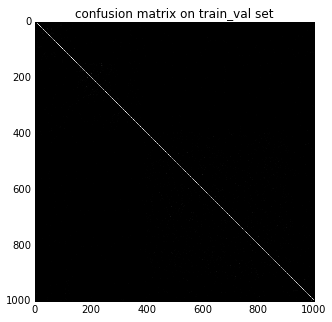

In [8]:
'''plot confusion matrix'''
confusion_mat = np.zeros((num_class,num_class))
for i in range(num_class):
    idx=np.nonzero(train_val_img_labels==i)[0]
    pred_label_ = pred_labels_train_val[idx]
    confusion_mat[i,:] = np.float64(np.bincount(pred_label_,minlength=num_class))/np.float64(len(idx))    
plt.figure()
plt.title('confusion matrix on train_val set')
plt.imshow(confusion_mat)

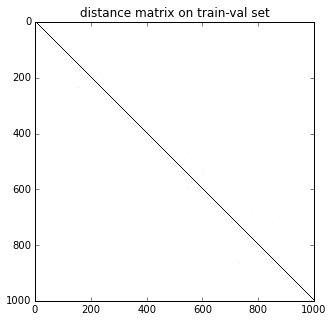

In [9]:
dist_mat = 1.0 - confusion_mat
'''set diagonal elements to 0'''
dist_mat[range(num_class),range(num_class)]=0
dist_mat = 0.5 * (dist_mat + dist_mat.T)
plt.figure()
plt.title('distance matrix on train-val set')
plt.imshow(dist_mat)

[-0.03162278 -0.03162278 -0.03162278 -0.03162278 -0.03162278 -0.03162278
 -0.03162278 -0.03162278 -0.03162278 -0.03162278]


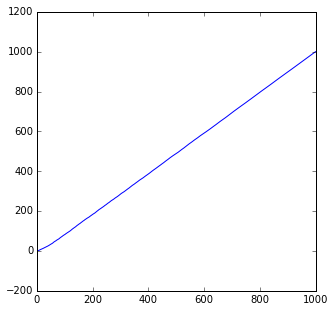

In [10]:
'''Laplacian eigenmap dimensionality reduction
construct adjacency graph W (symmetric) using k-NN'''
W=np.zeros((num_class,num_class))

# 89 clusters
k_nn, t, dim = 30, 0.8, 80

for i in range(num_class):
    idx=np.argsort(dist_mat[i,:])[1:k_nn+1]
    W[i,idx]=np.exp(-dist_mat[i,idx] / t)
    W[idx,i]=W[i,idx]
D=np.zeros(W.shape)
for i in range(num_class):
    D[i,i]=np.sum(W[i,:])
L=D-W
eig_val,eig_vec=scipy.linalg.eig(L,D)
ftr=eig_vec[:,1:dim+1]
print eig_vec[:10,0] # the 1st eigenvector should be all ones
eigval_cumsum = np.cumsum(np.real(eig_val))
plt.plot(eigval_cumsum)

89 clusters
cluster 0 size 8 
[great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias], [tiger shark, Galeocerdo cuvieri], [hammerhead, hammerhead shark], [electric ray, crampfish, numbfish, torpedo], [dugong, Dugong dugon], [barracouta, snoek], [sturgeon], [gar, garfish, garpike, billfish, Lepisosteus osseus],  
cluster 1 size 8 
[brambling, Fringilla montifringilla], [junco, snowbird], [robin, American robin, Turdus migratorius], [bulbul], [chickadee], [coucal], [bee eater], [hummingbird],  
cluster 2 size 3 
[jay], [magpie], [peacock],  
cluster 3 size 4 
[loggerhead, loggerhead turtle, Caretta caretta], [mud turtle], [terrapin], [box turtle, box tortoise],  
cluster 4 size 5 
[common iguana, iguana, Iguana iguana], [agama], [frilled lizard, Chlamydosaurus kingi], [Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis], [African crocodile, Nile crocodile, Crocodylus niloticus],  
cluster 5 size 8 
[tree frog, tree-frog], [America

(array([ 11.,  28.,  21.,  12.,   5.,   7.,   2.,   1.,   0.,   2.]),
 array([  2. ,   5.4,   8.8,  12.2,  15.6,  19. ,  22.4,  25.8,  29.2,
         32.6,  36. ]),
 <a list of 10 Patch objects>)

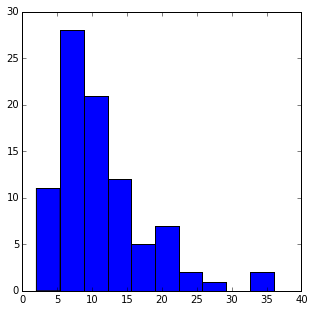

In [11]:
'''affinity propagation clustering'''
# 89 clusters
affinity_propagation_cluster = AffinityPropagation(damping=0.6, max_iter=5000, convergence_iter=50, copy=True)
cluster_labels = affinity_propagation_cluster.fit_predict(ftr)
unique_cluster_label = np.unique(cluster_labels)
n_cluster = unique_cluster_label.shape[0]
cluster_members=[None]*n_cluster
cluster_sizes = np.zeros((n_cluster))

print '%d clusters' % n_cluster
for i in range(n_cluster):
    idx = np.nonzero(cluster_labels == unique_cluster_label[i])[0]
    cluster_members[i]=list(idx)
    cluster_sizes[i] = len(idx)
    print 'cluster %d size %d ' % (i, len(idx))
    for j in range(len(idx)):
        print '[%s],' % label_names[idx[j]],
    print ' '  
plt.hist(cluster_sizes, bins=10)

In [12]:
''' compute a  histogram of the percentage of images 
that are classified as a label in the same cluster of its groundtruth label
'''
def plot_cluster_coverage(num_class, cluster_mbs,confusion_mat):
    cluster_coverage=np.zeros((num_class))
    for i in range(len(cluster_mbs)):
        for j in range(len(cluster_mbs[i])):
            class_id=cluster_mbs[i][j]
            cluster_coverage[class_id]=np.sum(confusion_mat[class_id,cluster_mbs[i]])
    n, bins, patches=plt.hist(cluster_coverage,bins=20)
    
def get_confusion_count(rows,cols,mat):
    mc,mr=np.meshgrid(cols,rows)
    return np.sum(mat[mr,mc])    

total_member 11249


(array([  2.,   2.,   1.,   5.,   9.,   3.,   2.,   9.,   1.,   8.,   7.,
          3.,   2.,   2.,   5.,   0.,   2.,   1.,   0.,  25.]),
 array([  26. ,   34.7,   43.4,   52.1,   60.8,   69.5,   78.2,   86.9,
          95.6,  104.3,  113. ,  121.7,  130.4,  139.1,  147.8,  156.5,
         165.2,  173.9,  182.6,  191.3,  200. ]),
 <a list of 20 Patch objects>)

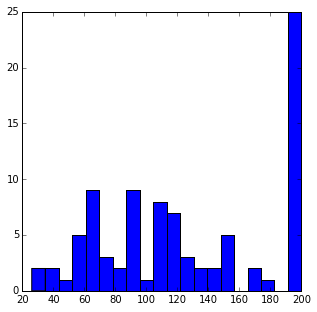

In [13]:
''' Adding extra classes to each branch to compensate for coarse misclassification at gating part
For each branch, sort all classes out of branch based on likelihood that they're misclassified into the branch
Take the top ones and also limit the total number of classes within each branch
'''
all_mb=range(num_class)
# for 89 clusters, v2.0
score_thres=1.0/(2.0*n_cluster)
max_exp_clu_size=200

extra_cluster_members=[None]*n_cluster
exp_cluster_members=[None]*n_cluster

for i in range(n_cluster):
    non_member = np.asarray(np.setdiff1d(range(num_class),cluster_members[i]))
#     print non_member.shape
    score=np.zeros((non_member.shape[0]))
    for j in range(non_member.shape[0]):
        idx=np.nonzero(train_val_img_labels==non_member[j])[0]
        lc_prob=probs[idx,:][:,cluster_members[i]]
        score[j]=np.mean(np.sum(lc_prob,axis=1))
    score_sorted=np.sort(score)[::-1]
    idx_sort=np.argsort(score)[::-1]
    idx2=np.nonzero(score_sorted>=score_thres)[0]
    if len(idx2)+len(cluster_members[i])> max_exp_clu_size:
        idx2=idx2[:(max_exp_clu_size-len(cluster_members[i]))]
    extra_cluster_members[i]=[non_member[idx_sort[id]] for id in idx2]
    exp_cluster_members[i]=cluster_members[i]+extra_cluster_members[i]
    assert len(exp_cluster_members[i])==np.unique(np.asarray(exp_cluster_members[i])).shape[0]

total_member=sum([len(cluster) for cluster in exp_cluster_members])
print 'total_member %d' % total_member
plt.hist([len(cluster) for cluster in exp_cluster_members],bins=20)

In [14]:
print len(exp_cluster_members[1])
print num_class
fine2multicoarse=[None]*num_class
for i in range(num_class):
    fine2multicoarse[i]=[]
for i in range(len(exp_cluster_members)):
    for j in range(len(exp_cluster_members[i])):
        fine2multicoarse[exp_cluster_members[i][j]] += [i]

63
1000


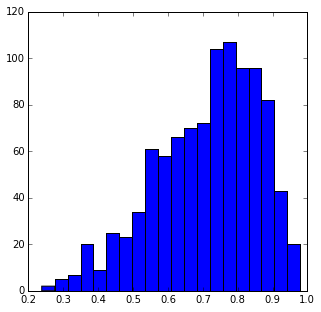

In [15]:
plot_cluster_coverage(num_class,cluster_members,confusion_mat)

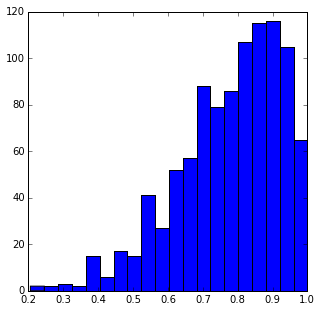

In [16]:
plot_cluster_coverage(num_class,exp_cluster_members,confusion_mat)

In [19]:
label_2_clusterid = np.zeros((num_class))
for i in range(n_cluster):
#     print 'cluster %d size %d' %(i, len(cluster_members[i]))
    for j in range(len(cluster_members[i])):
        label_2_clusterid[cluster_members[i][j]] = i

label_2_clusterid_file = caffe_root +\
'data/ilsvrc12/label_2_clusterid_%dclusters_nin4-small_new_version.txt' % (n_cluster)

with open(label_2_clusterid_file,'w') as f:
    for i in range(num_class):
        f.write('%d\n' % label_2_clusterid[i])

In [17]:
'''calculate coarse category classification accuracy when classification layer 
(FC layer) has one neuron for each fine category '''
'''
read 1000-class probabilities of 50K val set images
'''
val50k_img_list = caffe_root + 'data/ilsvrc12/val.txt'
val50k_img_names,val50k_img_labels=read_val_image_list(val50k_img_list)
val50k_img_labels=np.asarray(val50k_img_labels)

n_jobs=4
val50k_prob_ftr_dir = '/home/zyan3/local/proj/caffe_private_decision-cnn/examples/imagenet/hdcnn/nin4-small_new_version/val/_prob'
num_val50k=50000
val50k_prob = Parallel(n_jobs=n_jobs)\
(delayed(read_layer_ftr)(val50k_prob_ftr_dir, idx) for idx in range(num_val50k))
val50k_prob=np.asarray(val50k_prob)
val50k_pred_lbs=np.argmax(val50k_prob,axis=1)

50000 validation images 


In [20]:
'''calculate coarse category classification accuracy when classification layer 
(FC layer) has one neuron for each fine category '''
'''
read 1000-class probabilities of 50K val set images
'''
fine_accu=sum([1 if gt==pred else 0 for (gt,pred) in zip(val50k_img_labels, val50k_pred_lbs)])/float(len(val50k_img_labels))
coarse_accu=sum([1 if label_2_clusterid[gt]==label_2_clusterid[pred] else 0 for (gt,pred) in zip(val50k_img_labels,val50k_pred_lbs)])/float(len(val50k_img_labels))
print 'fine classification accuracy %4.3f' % fine_accu
print 'coarse classification accuracy %4.3f' % coarse_accu

fine classification accuracy 0.586
coarse classification accuracy 0.688


In [21]:
version ='v2.0'
example_dir = caffe_root + 'examples/imagenet/'
print 'example_dir',example_dir
if not os.path.exists(example_dir): 
    os.mkdir(example_dir)

save_dir = model_dir + '%dclusters/'%n_cluster 
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
save_dir += '%dclusters_%s/'%(n_cluster,version)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
local_save_dir = local_model_dir +'%dclusters/'%n_cluster 
local_save_dir += '%dclusters_%s/'%(n_cluster,version)

data_dir = caffe_root+'data/ilsvrc12/cluster_confusion_mat_%dclusters_nin_imagenet/' % (n_cluster)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
data_dir += '%s/' % (version)
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
print 'save_dir',save_dir
print 'local_save_dir',local_save_dir
print 'data_dir',data_dir
print 'n_cluster',n_cluster

example_dir /home/zyan3/proj/caffe_private_hdcnn/examples/imagenet/
save_dir /home/zyan3/proj/caffe_private_hdcnn/models/nin_imagenet/89clusters/89clusters_v2.0/
local_save_dir models/nin_imagenet/89clusters/89clusters_v2.0/
data_dir /home/zyan3/proj/caffe_private_hdcnn/data/ilsvrc12/cluster_confusion_mat_89clusters_nin_imagenet/v2.0/
n_cluster 89


In [22]:
'''for each cluster, write down the labels it owns'''
    
for i in range(n_cluster):
    with open(data_dir + 'cluster%02d_labels.txt' % i,'w') as f:
        for j in range(len(cluster_members[i])):
            f.write('%d\n' % cluster_members[i][j])
    
'''For each expanded cluster, prepare a training set with image's label remapped '''
for i in range(n_cluster):
    with open(data_dir + 'exp_cluster%02d_label_map.txt' % i,'w') as f:
        for j in range(len(exp_cluster_members[i])):
            f.write('%d %d\n' % (exp_cluster_members[i][j],j))

In [23]:
'''load (name, label) for training set image '''
train_img_list= caffe_root + 'data/ilsvrc12/train.txt'
train_img_names,train_img_labels=read_val_image_list(train_img_list)
train_img_labels=np.asarray(train_img_labels)

1281167 validation images 


In [24]:
'''for each cluster, write down a selective file list'''
for i in range(n_cluster):
    print '%d out of %d clusters' % (i+1,n_cluster)
    name_label_list=[]
    with open(data_dir+'selective_list_cluster%02d_train.txt'%i,'w') as f:
        for j in range(train_img_labels.shape[0]):
            tr_img_label = train_img_labels[j]
            count = exp_cluster_members[i].count(tr_img_label)
            if count > 1:
                print 'error count ',count
            if count == 1:
                index=exp_cluster_members[i].index(tr_img_label)
                name_label_list += [(train_img_names[j],index)]
        shuffle(name_label_list)

        for j in range(len(name_label_list)):
            f.write('%s %d\n'%(name_label_list[j][0],name_label_list[j][1]))
    print 'cluster:%02d. %d training images' %(i, len(name_label_list))
    
    
    name_label_list=[]
    with open(data_dir+'selective_list_cluster%02d_val.txt'%i,'w') as f:
        for j in range(val50k_img_labels.shape[0]):
            val_img_label=val50k_img_labels[j]
            count = exp_cluster_members[i].count(val_img_label)
            if count > 1:
                print 'error count',count
            if count == 1:
                index=exp_cluster_members[i].index(val_img_label)
                name_label_list += [(val50k_img_names[j],index)]
        shuffle(name_label_list)
        for j in range(len(name_label_list)):
            f.write('%s %d\n'%(name_label_list[j][0],name_label_list[j][1]))    
    print 'cluster:%02d. %d validation images' %(i, len(name_label_list))
    

1 out of 89 clusters
cluster:00. 88662 training images
cluster:00. 3450 validation images
2 out of 89 clusters
cluster:01. 81575 training images
cluster:01. 3150 validation images
3 out of 89 clusters
cluster:02. 45352 training images
cluster:02. 1750 validation images
4 out of 89 clusters
cluster:03. 65613 training images
cluster:03. 2550 validation images
5 out of 89 clusters
cluster:04. 91310 training images
cluster:04. 3550 validation images
6 out of 89 clusters
cluster:05. 128153 training images
cluster:05. 4950 validation images
7 out of 89 clusters
cluster:06. 171914 training images
cluster:06. 6650 validation images
8 out of 89 clusters
cluster:07. 150716 training images
cluster:07. 5850 validation images
9 out of 89 clusters
cluster:08. 112349 training images
cluster:08. 4350 validation images
10 out of 89 clusters
cluster:09. 214628 training images
cluster:09. 8350 validation images
11 out of 89 clusters
cluster:10. 184052 training images
cluster:10. 7150 validation images
12

In [25]:
def find_layer_id(lay_names,lay_name):
    for i in range(len(lay_names)):
        if lay_names[i]==lay_name:
            return i
    return -1

'''replace layer names with customized names'''
def customize_layer_name(text,lay_nams,lin_nums,insert_prefix, insert_suffix, lin_num_offset=0):
    for i in range(len(lay_nams)):
        lin_nums_=lin_nums[i]
        for lin_num in lin_nums_:
            lin_num = lin_num - lin_num_offset
            if lin_num > len(text):
                continue
            id=text[lin_num].find(lay_nams[i])
            if id<0:
                print '%s is not found in: %s' % (lay_nams[i],text[lin_num])
                continue
            text[lin_num]=text[lin_num][:id]+insert_prefix+lay_nams[i]\
            +insert_suffix+text[lin_num][id+len(lay_nams[i]):]
    return text

def set_lr_decay_mult(text, lr_mult, decay_mult):
    for i in range(len(text)):
        id=text[i].find('lr_mult')
        if id>=0:
            text[i]=text[i][:id]+'lr_mult: %3.2f\n'%lr_mult
        id=text[i].find('decay_mult')
        if id>=0:
            text[i]=text[i][:id]+'decay_mult: %3.2f\n'%decay_mult
    return text

In [26]:
net_def_fn='train_val.prototxt'
net_def=read_text(model_dir + net_def_fn)

lay_nams=['conv1', 'relu0','cccp1','relu1','cccp2','relu2','pool0',
          'conv2','relu3','cccp3','relu5','cccp4','relu6','pool2',
          'conv3', 'relu7','cccp5','relu8','cccp6','relu9','pool3','drop',
          'conv4-1024','relu10','cccp7-1024','relu11','cccp8-1024','relu12','pool4']

lin_nums=[]
for lay_nam in lay_nams:
    lin_nums_=[]
    for i in range(len(net_def)):
        id=net_def[i].find('"'+lay_nam+'"')
        if id>=0:
            lin_nums_+=[i]
    lin_nums += [lin_nums_]
print lin_nums

[[50, 51, 77, 78, 83], [79], [84, 85, 111, 112, 117], [113], [118, 119, 145, 146, 151], [147], [152, 153, 162], [163, 164, 191, 192, 197], [193], [198, 199, 225, 226, 231], [227], [232, 233, 259, 260, 265], [261], [266, 267, 276], [277, 278, 305, 306, 311], [307], [312, 313, 339, 340, 345], [341], [346, 347, 373, 374, 379], [375], [380, 381, 390, 391, 399], [392], [400, 401, 434, 435, 440], [436], [441, 442, 474, 475, 480], [476], [481, 482, 508, 509, 514], [510], [515, 516, 528, 542, 556]]


In [27]:
data_lay_rang = [0,48]
mid_lay_rang=[48,525]
share_lay_last_nm='drop'
share_lay_last_id=find_layer_id(lay_nams,share_lay_last_nm)
cccp8_lay_id=find_layer_id(lay_nams,'cccp8-1024')
print 'share_lay_last_id:%d' % share_lay_last_id
print 'cccp8_lay_id ',cccp8_lay_id
print lin_nums[share_lay_last_id+1]

train_source_line,train_batch_size_line,train_selective_list_line,\
test_source_line,test_batch_size_line, test_selective_list_line\
=18,19,21,41,42,44

net_conv4_quantization_kmean_num_cluster_line = 425
net_conv4_conserve_gpu_memory_test_line=430
net_cccp7_quantization_kmean_num_cluster_line = 465
net_cccp7_conserve_gpu_memory_test_line=470
net_cccp7_num_output_line = 493


share_lay_last_id:21
cccp8_lay_id  26
[400, 401, 434, 435, 440]


In [28]:
solver_proto_net_line,solver_proto_test_iter_line, \
solver_proto_base_lr_line, solver_proto_stepsize_line,\
solver_proto_max_iter_line,solver_proto_snapshot_line ,solver_proto_prefix_line=\
0,1,3,6,8,11,12

In [30]:
'''
two-time branch pre-training
train a separate CNN for each cluster 
For each cluster, prepare solver/train_test/deploy prototxt 
'''

'''change the paths as needed'''
train_lmdb_path = '/home/zyan3/local/data/imagenet/ilsvrc12/ilsvrc12_train_encoded_lmdb'
val_lmdb_path = '/home/zyan3/local/data/imagenet/ilsvrc12/ilsvrc12_val_encoded_lmdb'

# 89 clusters, last shared layer 'drop'
max_iter = [5000]
snapshot=[5000]
base_lr=[1e-2]
stepsize =[5000]


solver_proto=['solver.prototxt']
train_batch_size,test_batch_size=100,50


train_test_proto, deploy_proto=\
net_def_fn,\
'deploy.prototxt'

solver_proto_templates = [None]*len(solver_proto)
for i in range(len(solver_proto)):
    solver_proto_templates[i]=[]
    with open(model_dir + solver_proto[i],'r') as f:
        for line in f:
            solver_proto_templates[i]+=[line]

train_test_proto_template,deploy_proto_template=[],[]
with open(model_dir +  train_test_proto,'r') as f:
    for line in f:
        train_test_proto_template+=[line]
with open(model_dir + deploy_proto,'r') as f:
    for line in f:
        deploy_proto_template+=[line]

for i in range(n_cluster):
    num_class_branch = len(exp_cluster_members[i])
    net_nm = 'cluster%02d_%s'%\
    (i, train_test_proto)
    deploynet_nm = 'cluster%02d_%s'%\
    (i, deploy_proto)
    
    for j in range(len(solver_proto)):
        solver_proto_ = copy.deepcopy(solver_proto_templates[j])
        solver_proto_[solver_proto_net_line] = 'net: "%s%s"\n' % (save_dir,net_nm)
    
        solver_proto_[solver_proto_test_iter_line] = 'test_iter: %d\n' % (len(exp_cluster_members[i])*50/test_batch_size)
        solver_proto_[solver_proto_base_lr_line] = 'base_lr: %4.3f \n' % base_lr[j] 
        solver_proto_[solver_proto_stepsize_line] = 'stepsize: %d\n' % stepsize[j]       
        solver_proto_[solver_proto_max_iter_line] = 'max_iter: %d\n' % max_iter[j]
        solver_proto_[solver_proto_snapshot_line] = 'snapshot: %d\n' % snapshot[j]
        solver_proto_[solver_proto_prefix_line] = \
    'snapshot_prefix: "%scluster%02d"\n' \
    % (save_dir, i)
            
        with open(save_dir+'cluster%02d_%s' %(i, solver_proto[j]),'w') as f:
            f.writelines(solver_proto_)
    
    train_test_proto_ = copy.deepcopy(train_test_proto_template)
    train_test_proto_[train_source_line] = \
    '\t\tsource: "%s"\n' % train_lmdb_path
    
    train_test_proto_[train_batch_size_line] = '\t\tbatch_size: %d\n' % train_batch_size
    train_test_proto_[train_selective_list_line] = '\tselective_list: "%sselective_list_cluster%02d_train.txt"\n'%(data_dir,i)
    
    train_test_proto_[test_source_line] = \
    '\t\tsource: "%s"\n' % val_lmdb_path  
    
    train_test_proto_[test_batch_size_line] = '\t\tbatch_size: %d\n' % test_batch_size
    train_test_proto_[test_selective_list_line] = '\tselective_list: "%sselective_list_cluster%02d_val.txt"\n'%(data_dir,i)
    
    customize_layer_name(train_test_proto_,lay_nams[share_lay_last_id+1:],lin_nums[share_lay_last_id+1:],\
                         'cluster%02d_'%i, '', lin_num_offset=0)
    customize_layer_name(train_test_proto_,[lay_nams[cccp8_lay_id]],[lin_nums[cccp8_lay_id]],\
                         '', '_compact', lin_num_offset=0)
    
    train_test_proto_[:lin_nums[share_lay_last_id+1][0]-1]=\
    set_lr_decay_mult(train_test_proto_[:lin_nums[share_lay_last_id+1][0]-1], 0, 0)
    train_test_proto_[net_cccp7_num_output_line] = \
    '\t\t\t\tnum_output: %d\n' % num_class_branch
    
    train_test_proto_[net_conv4_quantization_kmean_num_cluster_line]='\t\tquantization_kmean_num_cluster: 128\n'
    train_test_proto_[net_conv4_quantization_kmean_num_cluster_line+2]=\
        '\t\tquantization_kmean_cluster_centers_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_conv4-1024_128_1152_kmean_cluster_centers.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    train_test_proto_[net_conv4_quantization_kmean_num_cluster_line+3]=\
        '\t\tquantization_kmean_cluster_indices_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_conv4-1024_128_1152_kmean_cluster_indices.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    train_test_proto_[net_conv4_conserve_gpu_memory_test_line]='\tconserve_gpu_memory_test: true\n'
    train_test_proto_[net_conv4_conserve_gpu_memory_test_line+1]='\tparameter_compress: false\n'
    
    
    train_test_proto_[net_cccp7_quantization_kmean_num_cluster_line]='\t\tquantization_kmean_num_cluster: 256\n'
    train_test_proto_[net_cccp7_quantization_kmean_num_cluster_line+2]=\
        '\t\tquantization_kmean_cluster_centers_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_cccp7-1024_256_512_kmean_cluster_centers.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    train_test_proto_[net_cccp7_quantization_kmean_num_cluster_line+3]=\
        '\t\tquantization_kmean_cluster_indices_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_cccp7-1024_256_512_kmean_cluster_indices.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    train_test_proto_[net_cccp7_conserve_gpu_memory_test_line]='\tconserve_gpu_memory_test: true\n'    
    train_test_proto_[net_cccp7_conserve_gpu_memory_test_line+1]='\tparameter_compress: false\n'    

    with open(save_dir+net_nm,'w') as f:
        f.writelines(train_test_proto_)
    

In [31]:
'''
prepare final HD-CNN solver prototxt files
'''

hdcnn_test_batch_size = 100

solver_proto=['solver.prototxt']
solver_proto_output=['hdcnn_solver.prototxt']

solver_proto_templates = [None]*len(solver_proto)
for i in range(len(solver_proto)):
    solver_proto_templates[i]=[]
    with open(model_dir + solver_proto[i],'r') as f:
        for line in f:
            solver_proto_templates[i]+=[line]
            
base_lr = [1e-4]
stepsize = [50000]
max_iter = [120000]
snapshot = [5000]

for j in range(len(solver_proto)):
    net_nm = 'hdcnn_train_val.prototxt'
    
    solver_proto_ = copy.deepcopy(solver_proto_templates[j])
    solver_proto_[solver_proto_net_line] = 'net: "%s%s"\n' % (save_dir,net_nm)

    solver_proto_[solver_proto_test_iter_line] = 'test_iter: %d\n'  % (num_val50k / hdcnn_test_batch_size)
    solver_proto_[solver_proto_base_lr_line] = 'base_lr: %4.3f \n' % base_lr[j] 
    solver_proto_[solver_proto_stepsize_line] = 'stepsize: %d\n' % stepsize[j]       
    solver_proto_[solver_proto_max_iter_line] = 'max_iter: %d\n' % max_iter[j]
    solver_proto_[solver_proto_snapshot_line] = 'snapshot: %d\n' % snapshot[j]
    solver_proto_[solver_proto_prefix_line] = \
'snapshot_prefix: "%shdcnn"\n' \
% (save_dir)    

    solver_fn=save_dir+solver_proto_output[j]
    print solver_fn
    with open(solver_fn,'w') as f:
        f.writelines(solver_proto_)

/home/zyan3/proj/caffe_private_hdcnn/models/nin_imagenet/89clusters/89clusters_v2.0/hdcnn_solver.prototxt


In [32]:
quantization_kmean_num_cluster={}
quantization_kmean_num_cluster['conv4-1024']=128
quantization_kmean_num_cluster['cccp7-1024']=256

quantization_kmean_num_segment={}
quantization_kmean_num_segment['conv4-1024']=384*3
quantization_kmean_num_segment['cccp7-1024']=512

iter_num=4000

bb_net_def = net_def

hdcnn_def = []

'''write data layer part'''
for lin_num in range(data_lay_rang[0],data_lay_rang[1]):
    hdcnn_def += [bb_net_def[lin_num]]
    
hdcnn_def[train_batch_size_line] = '\tbatch_size: 10\n'
hdcnn_def[test_batch_size_line] = '\tbatch_size: %d\n' % hdcnn_test_batch_size  


'''write gating part'''
for lin_num in range(mid_lay_rang[0],mid_lay_rang[1]):
    hdcnn_def += [bb_net_def[lin_num]]

'''write SOFTMAX fine-classification layer in the coarse category part'''
hdcnn_def +=['layer {\n',\
                        '\tname: "fine_branch_prob"\n',\
                        '\ttype: "Softmax"\n',\
                        '\tbottom: "pool4"\n',\
                        '\ttop: "fine_branch_prob"\n',\
                        '}\n']

'''write fine2multicoarse classification layer in the gating part'''
hdcnn_def +=['layer {\n',\
                        '\tname: "coarse_branch_prob"\n',\
                        '\ttype: "Fine2MultiCoarseProb"\n',\
                        '\tbottom: "fine_branch_prob"\n',\
                        '\ttop: "coarse_branch_prob"\n'\
                        '\tfine2multicoarse_prob_layer_param{\n',\
                        '\t\tnum_coarse: %d\n' % n_cluster]
for i in range(num_class):
    hdcnn_def += ['\t\tfine2multicoarse_param{\n']
    for j in range(len(fine2multicoarse[i])):
        hdcnn_def+= ['\t\t\tcoarse_id: %d\n' % fine2multicoarse[i][j]]
    hdcnn_def +=['\t\t}\n']
hdcnn_def += ['\t}\n',\
                         '}\n']

'''write independent layers in branching parts'''
for i in range(n_cluster):
    br_def=[]
    lin_num_offset = lin_nums[share_lay_last_id+1][0]-2

    for lin_num in range(lin_num_offset,mid_lay_rang[1]):
        br_def+=[bb_net_def[lin_num]]
    br_lay_nams=[lay_nams[id] for id in range(share_lay_last_id+1,len(lay_nams))]
    if i==0:
        print 'br_lay_nams',br_lay_nams
    br_lin_nums=[lin_nums[id] for id in range(share_lay_last_id+1,len(lay_nams))]

    br_def=customize_layer_name(br_def,br_lay_nams,br_lin_nums,'cluster%02d_'%i,\
                                '',lin_num_offset)

    br_def=customize_layer_name(br_def,[lay_nams[cccp8_lay_id]],[lin_nums[cccp8_lay_id]],'',\
                                '_compact',lin_num_offset)   

    br_def[net_cccp7_num_output_line-br_lin_nums[0][0]+2]='\tnum_output: %d\n' % len(exp_cluster_members[i])

    br_def += ['layer {\n',\
              'name: "cluster%02d_prob_compact"\n'%i,\
              'type: "Softmax"\n',\
              'bottom: "cluster%02d_pool4"\n'%i,\
              'top: "cluster%02d_prob_compact"\n'%i,\
              '}\n']

    line_num1 = net_conv4_quantization_kmean_num_cluster_line-lin_num_offset
    br_def[line_num1]='\t\tquantization_kmean_num_cluster: 128\n'
    br_def[line_num1+2]=\
        '\t\tquantization_kmean_cluster_centers_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_conv4-1024_128_1152_kmean_cluster_centers.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    br_def[line_num1+3]=\
        '\t\tquantization_kmean_cluster_indices_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_conv4-1024_128_1152_kmean_cluster_indices.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    br_def[line_num1+5]='\tconserve_gpu_memory_test: true\n'
    br_def[line_num1+6]='\tparameter_compress: false\n'
    
    line_num2=net_cccp7_quantization_kmean_num_cluster_line-lin_num_offset
    br_def[line_num2]='\t\tquantization_kmean_num_cluster: 256\n'
    br_def[line_num2+2]=\
        '\t\tquantization_kmean_cluster_centers_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_cccp7-1024_256_512_kmean_cluster_centers.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    br_def[line_num2+3]=\
        '\t\tquantization_kmean_cluster_indices_file: "%s%dclusters/%dclusters_%s/iter_40000/cluster%02d_cccp7-1024_256_512_kmean_cluster_indices.binaryproto"\n'%\
    (local_model_dir,n_cluster,n_cluster, version, i)
    br_def[line_num2+5]='\tconserve_gpu_memory_test: true\n'  
    br_def[line_num2+6]='\tparameter_compress: false\n'  
    
    for br_def_lin in br_def:
        hdcnn_def += [br_def_lin]

hdcnn_def += ['layer {\n',\
                        '\tname: "compact_probabilistic_average_prob"\n',\
                        '\ttype: "CompactProbabilisticAverageProb"\n']
for i in range(n_cluster):
    hdcnn_def+= ['\tbottom: "cluster%02d_prob_compact"\n'%i]
hdcnn_def+=['\tbottom: "coarse_branch_prob"\n',\
                       '\ttop: "compact_probabilistic_average_prob"\n',\
                       '\tcompact_probabilistic_average_prob_layer_param{\n',\
                       '\t\tnum_class:%d\n'%num_class]
for i in range(n_cluster):
    hdcnn_def+=['\t\tcompact_classify_layer_param{\n']
    for j in range(len(exp_cluster_members[i])):
        hdcnn_def+=['\t\t\tclass_id:%d\n'%exp_cluster_members[i][j]]
    hdcnn_def+=['\t\t}\n']
hdcnn_def+=['\t}\n',\
                       '}\n']

hdcnn_def += ['layer {\n',\
                        '\tname: "loss"\n',\
                        '\ttype: "MultinomialLogisticSparsityLoss"\n',\
                        '\tbottom: "compact_probabilistic_average_prob"\n',\
                        '\tbottom: "label"\n',\
                        '\tbottom: "coarse_branch_prob"\n',\
                        '\ttop: "loss"\n',\
                        '\tmultinomial_logistic_sparsity_loss_param{\n',
                        '\t\tsparsity_lamda: 5\n']
for i in range(n_cluster):
    hdcnn_def += ['\t\ttarget_sparsity: %4.3f\n'% (float(len(cluster_members[i])) / float(num_class))]

hdcnn_def+=['\t\t}\n',\
                      '\t}\n']

hdcnn_def+=['layer {\n',\
                       '\tname: "accuracy_top1"\n',\
                       '\ttype: "Accuracy"\n',\
                       '\tbottom: "compact_probabilistic_average_prob"\n',\
                       '\tbottom: "label"\n',\
                       '\ttop: "accuracy_top1"\n',\
                       '\tinclude {\n',\
                       '\t\tphase: TEST\n',\
                       '\t}\n',\
                       '\taccuracy_param {\n',\
                       '\t  top_k: 1\n',\
                       '\t}\n',\
                       '}\n']

hdcnn_def+=['layer {\n',\
                       '\tname: "accuracy_top5"\n',\
                       '\ttype: "Accuracy"\n',\
                       '\tbottom: "compact_probabilistic_average_prob"\n',\
                       '\tbottom: "label"\n',\
                       '\ttop: "accuracy_top5"\n',\
                       '\tinclude {\n',\
                       '\t\tphase: TEST\n',\
                       '\t}\n',\
                       '\taccuracy_param {\n',\
                       '\t  top_k: 5\n',\
                       '\t}\n',\
                       '}\n']   


hdcnn_net_def_fn = 'hdcnn_train_val.prototxt'
print 'write file:%s'%(save_dir+hdcnn_net_def_fn)
with open(save_dir+hdcnn_net_def_fn,'w') as f:
    for ln in hdcnn_def:
        f.write(ln)

br_lay_nams ['conv4-1024', 'relu10', 'cccp7-1024', 'relu11', 'cccp8-1024', 'relu12', 'pool4']
write file:/home/zyan3/proj/caffe_private_hdcnn/models/nin_imagenet/89clusters/89clusters_v2.0/hdcnn_train_val.prototxt


In [33]:
print save_dir
print model_dir
print hdcnn_net_def_fn

/home/zyan3/proj/caffe_private_hdcnn/models/nin_imagenet/89clusters/89clusters_v2.0/
/home/zyan3/proj/caffe_private_hdcnn/models/nin_imagenet/
hdcnn_train_val.prototxt


In [36]:
'''write shell script for testing HD-CNN'''
fine_category_component_checkpoint_dir = \
'/home/zyan3/proj/caffe_private_decision-cnn/examples/imagenet/imagenet12_NIN_89clusters/v2.0/'
script_fn=example_dir+'test_hdcnn_nin_imagenet_%dclusters_%s.sh'%(n_cluster,version)
print 'script: %s' % script_fn 
with open(script_fn,'w') as f:
    f.write('#!/bin/bash\n')
    f.write('TOOLS=build/tools\n')
    f.write('GLOG_logtostderr=1 $TOOLS/caffe test  \\\n')
    f.write('\t --model=%s%s \\\n'%(save_dir,hdcnn_net_def_fn))
    # f.write('\t%scifar100_NIN_float_crop_v2_iter_130000.caffemodel \\\n' % model_dir)
    f.write('\t --weights=')
    f.write('%snin_imagenet_train_iter_0.caffemodel,\\\n' % model_dir)
    for i in range(n_cluster):
        if i > 0:
            f.write(',\\\n')
        f.write('%scluster%02d_imagenet12_NIN_%dclusters_%s_iter_40000'%(fine_category_component_checkpoint_dir,i,n_cluster,version))
    f.write(' \\\n')
    f.write('\t--iterations=500 --gpu=0,1')

script: /home/zyan3/proj/caffe_private_hdcnn/examples/imagenet/test_hdcnn_nin_imagenet_89clusters_v2.0.sh
